In [1]:
## 5.5 リサンプリング
### 5.5.2 系統サンプリングによるリサンプリングの実装
"""
"""
import sys

# 推奨された方法ではない。
# 参照:https://note.com/iamhacchin/n/n8eb3efafadf9
sys.path.append("..")
from scripts.robot import *
from scipy.stats import multivariate_normal
import random
import copy


In [2]:
class Particle:
    def __init__(self, init_pose, weight):
        self.pose = init_pose
        self.weight = weight

    def motion_update(self, nu, omega, time, noise_rate_pdf):
        # 式(5,9)の実行
        ns = noise_rate_pdf.rvs()
        # 以下2行で式(5.12)を実行
        pnu = (
            nu
            + ns[0] * math.sqrt(abs(nu) / time)
            + ns[1] * math.sqrt(abs(omega) / time)
        )
        pomega = (
            omega
            + ns[2] * math.sqrt(abs(nu) / time)
            + ns[3] * math.sqrt(abs(omega) / time)
        )

        # ノイズを加えた速度、角速度をstate_transitionに入力し、姿勢を更新
        self.pose = IdealRobot.state_transition(pnu, pomega, time, self.pose)

    def observation_update(self, observation, envmap, distance_dev_rate, direction_dev):
        for d in observation:
            obs_pos = d[0]
            obs_id = d[1]

            # パーティクルの位置と地図からランドマークの距離と方角を算出
            pos_on_map = envmap.landmarks[obs_id].pos
            particle_suggest_pos = IdealCamera.observation_function(
                self.pose, pos_on_map
            )

            # 尤度の計算
            distance_dev = distance_dev_rate * particle_suggest_pos[0]
            cov = np.diag(np.array([distance_dev**2, direction_dev**2]))
            self.weight *= multivariate_normal(mean=particle_suggest_pos, cov=cov).pdf(
                obs_pos
            )


In [3]:
class Mcl:
    def __init__(
        self,
        envmap,
        init_pose,
        num,
        motion_noise_stds={"nn": 0.19, "no": 0.001, "on": 0.13, "oo": 0.2},
        distance_dev_rate=0.14,
        direction_dev=0.05,
    ):
        # 重みの初期値を1/N(N=パーティクルの個数。ここではnum)
        self.particles = [Particle(init_pose, 1.0 / num) for i in range(num)]
        self.map = envmap
        # distance_dev_rate = σl
        # direction_dev = σφ
        self.distance_dev_rate = distance_dev_rate
        self.direction_dev = direction_dev

        # motion_noise_stdsは式(5.9)のσabに対応する
        v = motion_noise_stds
        # np.diagは与えられたリストの要素を対角成分に持つ対角行列を作って返す。
        c = np.diag([v["nn"] ** 2, v["no"] ** 2, v["on"] ** 2, v["oo"] ** 2])
        # 式(5.9)用の正規分布を用意。共分散行列のみ与える。平均はデフォルト0なのでそのまま。
        self.motion_noise_rate_pdf = multivariate_normal(cov=c)

    def motion_update(self, nu, omega, time):
        # 各パーティクルのmotion_updateメソッドを呼び出す
        for p in self.particles:
            p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)

    def observation_update(self, observation):
        for p in self.particles:
            p.observation_update(
                observation, self.map, self.distance_dev_rate, self.direction_dev
            )
        self.resampling()

    def resampling(self):
        # 重みのリストを作る
        # 重みを累積して足していく（最後の要素が重みになる）
        ws = np.cumsum([e.weight for e in self.particles])
        if ws[-1] < 1e-100:
            # 重みの和が0に丸め込まれるとエラーになるので小さな数を足しておく。
            ws = [e + 1e-100 for e in ws]
        # 正規化されていない場合はステップが「重みの合計/N」になる。
        step = ws[-1] / len(self.particles)
        r = np.random.uniform(0.0, step)
        cur_pos = 0
        # 抽出するパーティクルのリスト
        ps = []
        while len(ps) < len(self.particles):
            if r < ws[cur_pos]:
                ps.append(self.particles[cur_pos])
                r += step
            else:
                cur_pos += 1

        # 選んだリストからパーティクルを取り出し、重みを均一に
        self.particles = [copy.deepcopy(e) for e in ps]
        # 重みの正規化
        for p in self.particles:
            p.weight = 1.0 / len(self.particles)

    def draw(self, ax, elems):
        # particleのx座標
        xs = [p.pose[0] for p in self.particles]
        # particleのy座標
        ys = [p.pose[1] for p in self.particles]
        # particleの向きを矢印として描画するための要素x,y
        # 重みを反映
        vxs = [
            math.cos(p.pose[2]) * p.weight * len(self.particles) for p in self.particles
        ]
        vys = [
            math.sin(p.pose[2]) * p.weight * len(self.particles) for p in self.particles
        ]

        elems.append(
            ax.quiver(
                xs,
                ys,
                vxs,
                vys,
                angles="xy",
                scale_units="xy",
                scale=1.5,
                color="blue",
                alpha=0.5,
            )
        )


In [4]:
class EstimationAgent(Agent):
    def __init__(self, time_interval, nu, omega, estimator):
        super().__init__(nu, omega)
        self.estimator = estimator
        self.time_interval = time_interval

        self.prev_nu = 0.0
        self.prev_omega = 0.0

    def decision(self, observation=None):
        self.estimator.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.prev_nu, self.prev_omega = self.nu, self.omega
        self.estimator.observation_update(observation)
        return self.nu, self.omega

    def draw(self, ax, elems):
        self.estimator.draw(ax, elems)


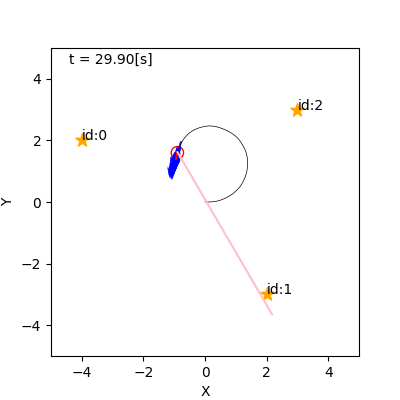

In [5]:
def trial():  ###mcl_obs_prepare
    time_interval = 0.1
    world = World(30, time_interval, debug=True)

    ### 地図を生成して3つランドマークを追加 ###
    m = Map()
    for ln in [(-4, 2), (2, -3), (3, 3)]:
        m.append_landmark(Landmark(*ln))
    world.append(m)

    ### ロボットを作る ###
    initial_pose = np.array([0, 0, 0]).T  # 初期位置を原点に
    estimator = Mcl(m, initial_pose, 100)
    a = EstimationAgent(
        time_interval, 0.2, 10.0 / 180 * math.pi, estimator
    )  # EstimationAgentに
    r = Robot(initial_pose, sensor=Camera(m), agent=a, color="red")
    world.append(r)

    %matplotlib widget
    world.draw()


trial()
